# Z-test

In [1]:
from scipy.stats import (
    norm, binom, expon
)
import numpy as numpy
from seaborn import distplot
from matplotlib import pyplot
import seaborn

import sys
sys.path.append('.')

In [2]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert): 
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'
    
    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [3]:
inverse_plot_colorscheme()

Начиная с сегодняшней лекции мы будем анализировать средние значения выборок. Для начала зададимся вопросом: **зачем вообще их анализировать?**

Можно привести следующие реальные примеры из практики:
1. Прирост выручки. 
    - Если растет суммарное значение $\Leftrightarrow$ растет среднее значение. Поэтому эту задачу можно переформулировать как рост среднего чека, или ARPU.
2. Увеличение числа покупок.
3. Уменьшение оттока пользователей.

...

Анализ среднего значения является одной из наиболее популярных задач в работе аналитика, поэтому очень важно уметь ее решать.

----

Далее, для вывода всех критериев нам потребуется нормальное распределение. *Потому что именно этому распределению подчиняется среднее выборок*.

Поэтому давайте посмотрим, что это вообще такое, как с ним работать в Python и какие у него есть свойства.

## 1 часть: нормальное распределение

Нормальное распределение $\mathcal{N}(\mu, \sigma^2)$ — непрерывное распределение, в котором плотность убывает с ростом расстояния от $\mu$ по экспоненте квадрата.

$$
f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2},
$$

где
- $\mu$ &mdash; параметр сдвига: насколько центр сдвинут относительно 0
- $\sigma^2$ &mdash; параметр масштаба: насколько "пологий" будет график распределения

<img src="https://raw.githubusercontent.com/dimalunin2016/pictures/main/image%20(8).png" width="1000" height="200" />


### Как пользоваться нормальным распределением в Python

Пусть мы хотим задать распределение $\mathcal{N}(\mu, \sigma^2)$. Для этого есть [класс](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) `norm`. 

*Параметры инициализации*
- `loc` &mdash; это $\mu$
- `scale` &mdash; это $\sigma$, или **стандартное отклонение**. Не дисперсия!

Методы класса:
- `norm().cdf(x)` &mdash; функция распределения в точке x. $P(\xi \leq x)$
- `norm().ppf(q)` &mdash; получить квантиль распределения
- `norm().pdf(x)` &mdash; получить плотность распределения в точке x.

In [4]:
# инициализация
stand_norm = norm(loc=0, scale=1)

In [5]:
# cumulative distribution function
print(f"P(X <= 2)  = {stand_norm.cdf(x=2)}")
print(f"или так {norm(loc=0, scale=1).cdf(x=2)}")
# можно указывать массивы
print(f"[P(X <= 2), P(X <= -1)] = {stand_norm.cdf([2, -1])}")

P(X <= 2)  = 0.9772498680518208
или так 0.9772498680518208
[P(X <= 2), P(X <= -1)] = [0.97724987 0.15865525]


In [6]:
# percent point function
print(f"quantile 0.975 = {stand_norm.ppf(0.975)}")

quantile 0.975 = 1.959963984540054


In [7]:
# probability density function
print(f"pdf(0) = {stand_norm.pdf(0)}")

pdf(0) = 0.3989422804014327


Нарисуем график нормального распределения:

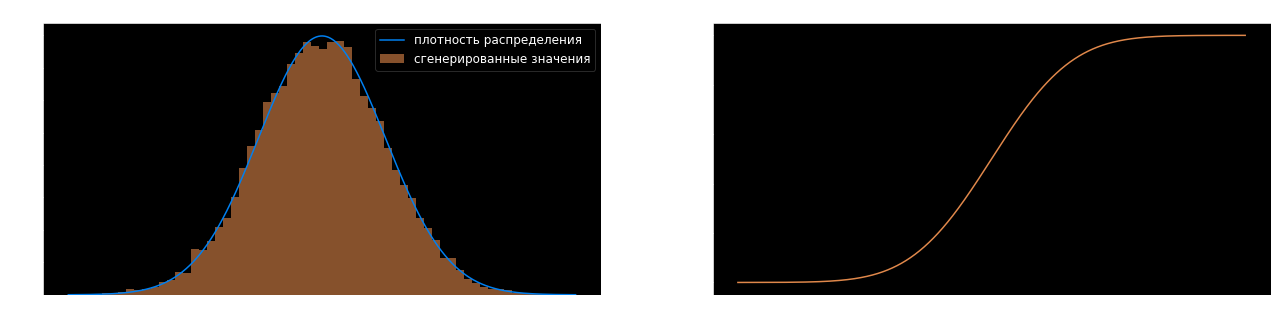

In [8]:
check_distr = norm(loc=0, scale=2)
x = numpy.linspace(-8, 8, 1000) # расставит на равных расстояниях друг от друга 1000 точек от -8 до 8
pdf = check_distr.pdf(x)
cdf = check_distr.cdf(x)
sample = check_distr.rvs(10000)

pyplot.figure(figsize=(22, 5))

pyplot.subplot(1, 2, 1)
pyplot.title('Визуализация плотности', fontsize=12, color='white')
pyplot.hist(sample, bins='auto', density=True, alpha=0.6, label='сгенерированные значения') # rvs
pyplot.plot(x, pdf, label='плотность распределения') # pdf
pyplot.legend(fontsize=12)
###################################
pyplot.subplot(1, 2, 2)
pyplot.title('Визуализация функции распределения', fontsize=12)
pyplot.plot(x, cdf) # cdf
pyplot.show()

### Свойства нормального распределения

- $\xi_1 \sim \mathcal{N}(\mu_1, \sigma_1^2),\ \xi_2 \sim \mathcal{N}(\mu_2, \sigma_2^2) \Rightarrow \xi_1 + \xi_2 \sim \mathcal{N}(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)$, [док-во](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#:~:text=This%20means%20that%20the%20sum,squares%20of%20the%20standard%20deviations)
- $a \xi_1 \sim \mathcal{N}(a\mu_1, a^2\sigma_1^2)$, док-во на вас)

Покажем корректность этих формул на практике:

Сначала проверим на примере формулу 1:

In [9]:
# примеры
first_mean = 3
first_var = 4

second_mean = -1
second_var = 2

first_dist = norm(loc=first_mean, scale=numpy.sqrt(first_var))
second_dist = norm(loc=second_mean, scale=numpy.sqrt(second_var))
# Важно scale=numpy.sqrt(first_var + second_var)
checking_sum_distr = norm(loc=first_mean + second_mean, scale=numpy.sqrt(first_var + second_var))

1. Нагенерируем выборку из 1 и 2 распределений и просуммируем их.
2. Далее, построим эмпирическую плотность распределения и сравним ее с настоящей на графике.

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


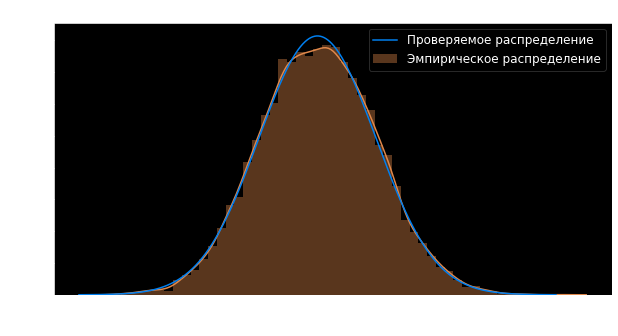

In [10]:
first_sample = first_dist.rvs(10000)
second_sample = second_dist.rvs(10000)
sum_sample = first_sample + second_sample

x = numpy.linspace(-8, 12, 1000)

pyplot.figure(figsize=(10, 5))
pyplot.title('Проверка распределений', fontsize=12)
# Эта функция строит как гисторгамму значений, так и эмпирическое распределение
distplot(sum_sample, label='Эмпирическое распределение')
pyplot.plot(x, checking_sum_distr.pdf(x), label='Проверяемое распределение')
pyplot.legend(fontsize=12)
pyplot.xlabel('X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.show()

Видно, что распределения примерно совпали! А значит мы удостоверились, что формула верна. 

Второе утверждение можно проверить таким же образом на практике.

## 2 часть: ЦПТ

Для начала вспомним теорему, которая является основополагающей теоремой для всех критериев, которые мы рассмотрим в ближайших лекциях.

**Центральная предельная теорема**

*Формулировка теоремы*

Пусть $\xi_1, ..., \xi_n$ &mdash; **независимо** одинаково распределенные случайные величины, у которых сущестуют мат. ожидание и дисперсия: $E [\xi_i] = \mu < \infty$ и $Var[\xi_i] = \sigma^2 < \infty$. тогда $\sqrt{n}\dfrac{\overline \xi - \mu}{\sqrt{\sigma^2}}$ [сходится по распределению](https://en.wikipedia.org/wiki/Convergence_in_distribution) к $\mathcal{N}(0, 1)$.

*Что это значит на практике*

Если случайные величины в эксперименте **независимы и одинаково распределены** и ваша выборка **достаточно большая**, то вы можете полагать, что 
$$
\sqrt{n}\dfrac{\overline \xi - \mu}{\sqrt{\sigma^2}} \sim \mathcal{N}(0, 1),
$$

где $\mu, \sigma^2$ &mdash; мат. ожидание и дисперсия одного элемента выборки.


*Дополнение*

Случайные величины могут быть слабо зависимы друг от друга и слегка по-разному распределены. Центральная предельная теорема все еще будет [верна](https://en.wikipedia.org/wiki/Stable_distribution#A_generalized_central_limit_theorem).


Несмотря на ослабление условий, **всегда держите в голове условия применимости ЦПТ**: забыв про них и не проверив свой критерий, вы можете некорректно проанализировать свой AB-тест.

### Визуализация ЦПТ

Чтобы лучше понимать, как работает ЦПТ, я предлагаю визуализировать теорему: посмотрим на распределение средних значений в разных выборках. Как мы это сделаем?

- Чтобы посмотреть, что некоторая случайная величина из нормального распределения, нам нужна выборка этих случайных величин.
- В данном случае нам нужна выборка статистик из ЦПТ. Поэтому нам нужно нагенерировать N выборок по M элементов в каждой.
    - По каждой выборке надо посчитать нормированное среднее по M элементам.
    - В итоге мы получим выборку из N элементов.
    - Она и должна быть из нормального распределения.

In [11]:
def visualize_CLT(sample_generator, expected_value, variance):
    """
        Функция-визуализатор ЦПТ. Строит:
            - гисторгамму статистики ЦПТ,
            - эмпирическую плотность,
            - плотность нормального распределения.
        Параметры:
            - sample_generator: функция-генератор выборки. Не принимает ничего на вход
            - expected_value: мат. ожидание выборки
            - variance: дисперсия выборки
    """

    numpy.random.seed(42)
    N = 5000
    clt_sample = []
    for _ in range(N):
        # генерируем N раз выборку
        sample = sample_generator()

        # считаем статистику из ЦПТ
        sample_size = len(sample)
        statistic = numpy.sqrt(sample_size) * (numpy.mean(sample) - expected_value) / numpy.sqrt(variance)

        #сохраняем
        clt_sample.append(statistic)

    x = numpy.linspace(-4, 4, 1000)
    pyplot.figure(figsize=(10, 5))
    pyplot.title('Распределение средних значений', fontsize=12)
    seaborn.distplot(clt_sample, label='Эмпирическое распределение')
    pyplot.plot(x, norm().pdf(x), label='$\mathcal{N}(0, 1)$')
    pyplot.legend(fontsize=12)
    pyplot.xlabel('X', fontsize=12)
    pyplot.ylabel('Плотность', fontsize=12)
    pyplot.show()

Для начала проверим биномиальное распределение, которое мы уже рассматривали ранее.

In [12]:
def binom_generator(p, n, size):
    return binom(p=p, n=n).rvs(size)

/root/Python3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


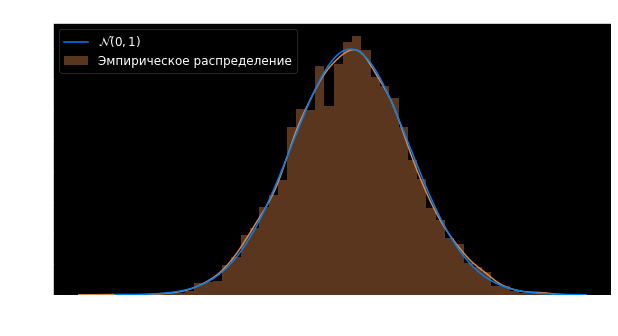

In [13]:
p = 0.01
n = 20
size = 5000

# мы оборачиваем binom_generator в lambda, чтобы функция не принимала параметры на вход
visualize_CLT(lambda: binom_generator(p, n, size), 
              expected_value = p * n, 
              variance = n * p * (1 - p)
             )

Эмпирическая плотность "почти" совпала с истинной. А что если уменьшить выборку, по которой считается среднее?

/root/Python3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


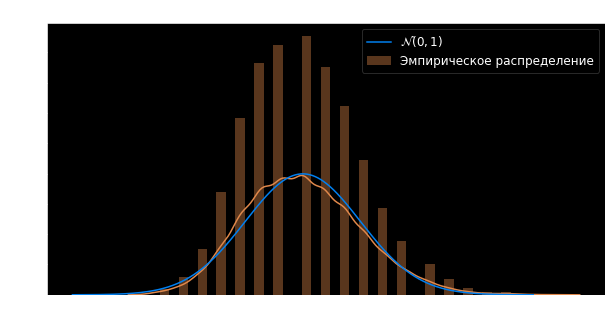

In [14]:
p = 0.01
n = 20
size = 40

visualize_CLT(lambda: binom_generator(p, n, size), 
              expected_value = p * n, 
              variance = n * p * (1 - p)
             )

Стало сильно хуже: появились пробелы в распределении, да и сама эмпирическая функция распределения слегка "сдвинута". Так что наш эксперимент подтвердил важность размера выборки для корректной работы ЦПТ.


Теперь давайте посмотрим на другое распределение: [экспоненциальное](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html).

In [15]:
def expon_generator(expected_value, size):
    return expon(scale=expected_value).rvs(size)

/root/Python3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


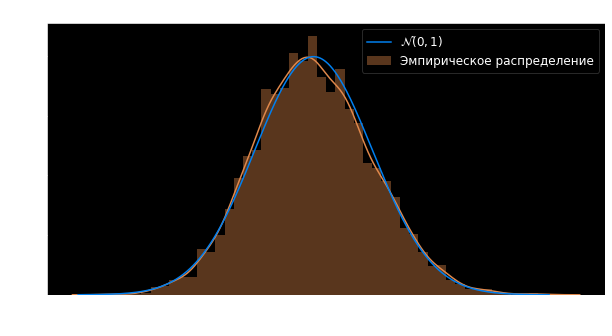

In [16]:
expected_value = 24
size = 400

visualize_CLT(lambda: expon_generator(expected_value, size), 
              expected_value=expected_value, variance=expected_value ** 2)

Видим, что и тут все хорошо работает!

**Эквивалентные формулировки ЦПТ**

$$\begin{align}
\sqrt{n}\dfrac{\overline \xi - \mu}{\sqrt{\sigma^2}} &\sim \mathcal{N}(0, 1) \stackrel{св. 2}{\Leftrightarrow}\\
\overline \xi - \mu &\sim \mathcal{N}\left(0, \dfrac{\sigma^2}{n} \right) \Leftrightarrow\\
\dfrac{\underset{i=1}{\overset{n}{\sum}} \xi_i}{n} &\sim \mathcal{N}\left(\mu, \dfrac{\sigma^2}{n} \right) \Leftrightarrow\\
\underset{i=1}{\overset{n}{\sum}} \xi_i &\sim \mathcal{N}\left(n \cdot \mu, n \cdot \sigma^2 \right)
\end{align}$$

А значит сумма случайных величин также распределена нормально

## Часть 3: Z-критерий Фишера


> 📈 **Задача**
>
> Вы придумали идею для стартапа, где курьеры собирают заказы для клиентов и отвозят им на дом. Стоимость заказа в вашем стартапе &mdash; 10К ₽, а стоимость работы курьера &mdash; 5К ₽.
Специфика вашего стартапа такова, что есть большой риск возврата без оплаты. С учетом стоимостей, инвесторы готовы проспонсировать вам инфраструктуру и привлечение клиентов, если вы покажете, что шанс оплаты заказа больше 50%.
Вы своими силами обработали 30 заказов, 19 из них были успешно оплачены. Достаточно ли этих данных, чтобы убедить инвесторов?


У нас есть выборка $X_1,\ X_2,\ ...,\ X_n,\ X_i \sim \text{Bernoulli}(\mu)$

$H_0: \mu =\mu_0 = 0.5\ vs.\ H_1: \mu > 0.5$


**Как мы решали задачу ранее**

- $T(X^n) = \underset{i=1}{\overset{n}{\sum}} X_i,\ T \overset{H_0}{\sim} \text{Binom} (n, \mu_0)$
- Пусть реализация $T(X^n) = t$. Тогда 
- $\text{p-value} = P_{H_0}(T(X^n) \geq t) = 1 - P_{H_0}(T(X^n) < t)$
- Или, если переписать на языке Python `p-value = 1 - binom.cdf(t - 1, n, mu0)`

In [17]:
def get_pvalue_by_old_logic(n, mu0, t):
    return 1 - binom.cdf(t-1, n=n, p=mu0)

In [18]:
n = 30
mu0 = 0.5
t = 19

old_p_value = get_pvalue_by_old_logic(n, mu0, t)
print(f"p-value, полученное по старой, корректной формуле: {old_p_value}")

p-value, полученное по старой, корректной формуле: 0.10024421103298664


А теперь посмотрим, что нам говорит ЦПТ.
- При достаточно большом размере выборки $\underset{i=1}{\overset{n}{\sum}} X_i \sim \mathcal{N}\left(n \cdot \mu_0, n \cdot \sigma^2 \right)$,
- $X_i \overset{H_0}{\sim} \text{Bernoulli} (\mu_0)$
- $\sigma^2 = \mu_0 \cdot (1 - \mu_0)$
- $\text{p-value} = P_{H_0}(T(X^n) \geq t)$. Или `p-value = 1 - norm(loc=sum_mu, scale=sum_std).cdf(t)`. При этом в этот раз мы смотрим статистику не в 
точке t-1, как делали ранее, а в точке t. **Так как у нас непрерывное распределение, то нам не нужно вычитать 1**:
    - в случае нормального распределения: $P(T(X^n) \geq t) = P(T(X^n) > t) = 1 - P(T(X^n) \leq t) $;
    - в случае биномиального распределения: $P(T(X^n) \geq t) = 1 - P(T(X^n) \leq t - 1)$.

In [19]:
def get_pvalue_by_normal_approx(n, mu0, t):
    sum_mu = n * mu0
    sum_variance = n * mu0 * (1 - mu0)
    sum_std = numpy.sqrt(sum_variance)

    return 1 - norm(loc=sum_mu, scale=sum_std).cdf(t)

In [20]:
normal_dist_p_value = get_pvalue_by_normal_approx(n, mu0, t)
print(f"p-value, полученное из приближения нормальным распределением: {normal_dist_p_value}")

p-value, полученное из приближения нормальным распределением: 0.07206351740800765


Мы видим, что значения не очень-то и совпали. Но, как мы помним, нормальная аппроксимация работает только с некоторого большого n. Поэтому давайте попробуем повторить эксперимент с большим n.

In [21]:
n = 3000
mu0 = 0.5
t = 1544

old_p_value = get_pvalue_by_old_logic(n, mu0, t)
print(f"p-value, полученное по старой, корректной формуле: {old_p_value}")
normal_dist_p_value = get_pvalue_by_normal_approx(n, mu0, t)
print(f"p-value, полученное из приближения нормальным распределением: {normal_dist_p_value}")

p-value, полученное по старой, корректной формуле: 0.056090883742748066
p-value, полученное из приближения нормальным распределением: 0.05406527265575145


Мы видим, что отличие теперь только в 3 знаке после запятой. А не во втором, как раньше. Чем больше мы будем брать выборку, тем меньше будет ошибка. Что, в приципе, и утверждает ЦПТ.

Но на самом деле, это **не Z-критерий Фишера** (не в чистом виде). Поэтому теперь рассмотрим искомый критерий.

### Z-критерий Фишера

$H_0: \mu =\mu_0\ vs.\ H_1: \mu > \mu_0$
- Статистика $Z(X) = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{\sigma^2}}$
- При достаточно большом размере выборки $Z(X) \overset{H_0}{\sim} \mathcal{N}(0, 1)$ (по ЦПТ)
- Односторонний критерий: $\left\{Z(X) \geq z_{1 - \alpha} \right\}$
    - p-value = $1 - \Phi(z)$, где z &mdash; реализация статистики $Z(X)$, $\Phi(z)$ &mdash; функция распределения $\mathcal{N}(0, 1)$
- Двусторонний критерий: $\left\{Z(X) \geq z_{1 - \frac{\alpha}{2}} \right\} \bigcup \left\{Z(X) \leq -z_{1 - \frac{\alpha}{2}} \right\} $
    - p-value = $2\cdot \min \left[{\Phi(z), 1 - \Phi(z)} \right]$, где z &mdash; реализация статистики $Z(X)$

In [22]:
def z_criterion_pvalue(sample_mean, sample_size, mu0, variance):
    Z_statistic = numpy.sqrt(sample_size) * (sample_mean - mu0) / numpy.sqrt(variance)
    return 1 - norm().cdf(Z_statistic) 

Проверим, что все корректно:

In [23]:
n = 30
t = 19
mu0 = 0.5
variance = mu0 * (1 - mu0)

old_p_value = get_pvalue_by_old_logic(n, mu0, t)
print(f"p-value, полученное по старой, корректной формуле: {old_p_value}")
normal_p_value = get_pvalue_by_normal_approx(n, mu0, t)
print(f"p-value, полученное из приближения нормальным распределением: {normal_p_value}")
z_pvalue = z_criterion_pvalue(t/n, n, mu0, variance)
print(f"Z-тест p-value: {z_pvalue}")

p-value, полученное по старой, корректной формуле: 0.10024421103298664
p-value, полученное из приближения нормальным распределением: 0.07206351740800765
Z-тест p-value: 0.07206351740800765


Видим, что Z-критерий совпадает с предыдущим нормальным приближением, то есть критерии эквивалентны.

Но остался последний вопрос: *можно ли уточнить результаты Z-теста для биномиального распределения при малых размерах выборок?* 

----

### Поправка на непрерывность

Для начала давайте визуализируем функцию `p-value(t)` критериев, описанных выше: 
- `p-value` критерия, основанного на нормальном приближении
    - здесь простая формула: надо реализовать `1 - norm.cdf(t)`
- `p-value` биномиального критерия. Посчитаем его в 2 случаях:
    - t &mdash; нецелое число. Рассмотрим на примере
        - Пусть `t=19.5`. 
        p-value $= P(T(X) \geq t) = P(T(X) \geq 19.5) = 1 - P(T(X) < 19.5) =|P(T(X) = 19.5) = 0|= 1 - P(T(X) \leq 19.5)$. Заметим, что последняя вероятность &mdash; функция распределения. Поэтому
            - `p-value = 1 - binom.cdf(t, n, mu0)`
    - t &mdash; целое число.
        - Пусть `t=19`. p-value $= P(T(X) \geq t) = P(T(X) \geq 19) = 1 - P(T(X) < 19) = 1 - P(T(X) \leq 18)$. 
            - `p-value = 1 - binom.cdf(t-1, n, mu0)`
            - а также `p-value(t) = 1 - binom.cdf(t-a, n, mu0) = p-value(t-a)`, где `0 < a < 1`. Например, `p-value(19) = p-value(18.9)`.
    - То есть, чтобы изобразить биномиальное p-value, надо изобразить функцию `p-value = 1 - binom.cdf(t, n, mu0)`. Значения p-value в целых точках будут лежать на правых концах вертикальных отрезков.

In [24]:
def cmp_pvalue_binom_and_norm(n, mu0, t, add_to_x=0):
    """
        Функция для сравнения функций pvalue у биномиального критерия и нормальной аппроксимации.
        Строит графики:
            - binom pvalue
            - norm pvalue
            - большими точками обозначены pvalue в точке t, полученные 2 способами.
        Параметры:
            - n: число значений в выборке
            - mu0: конверсия при корректности нулевой гипотезы
            - t: число доставок с оплатой
            - add_to_x: параметр для добавления к T(X) в нормальном распределении.
    """

    x_axis = numpy.linspace(0, n, 1000)
    dots_to_show = numpy.arange(0, n + 1, 1)
    # параметры нормального распределения
    sum_mu = n * mu0
    sum_variance = n * mu0 * (1 - mu0)
    sum_std = numpy.sqrt(sum_variance)

    # сами распределения
    binom_dist = binom(n=n, p=mu0)
    norm_dist = norm(loc=sum_mu, scale=sum_std)

    pyplot.figure(figsize=(20, 7))
    pyplot.title('Сравнение p-value: биномиального и нормального', fontsize=12)
    # строим красивое дискретное бернуллиевское распределение
    # сначала горизонтальные линии
    pyplot.hlines(1 - binom_dist.cdf(x_axis), x_axis[:-1], x_axis[1:], 
               color='white', linestyle='-')
    # вертикальные линии, которых на самом деле нет
    pyplot.vlines(x_axis, 1 - binom_dist.cdf(x_axis[:-1]), 1 - binom_dist.cdf(x_axis[1:]), 
               color='white', linestyle=':')
    # дискретные точки в распределении
    pyplot.scatter(dots_to_show, 1 - binom_dist.cdf(dots_to_show-1), color='white', 
                alpha=1, linewidths=0.5,
                label=f'Binom pvalue = 1-binom.cdf(x-1)')
    # pvalue через биномиальное распределение
    pyplot.scatter(t, 1 - binom_dist.cdf(t - 1), color='white', marker='o',
                alpha=1, s=100, label=f'binom p-value({t})')
    # аппроксимирующее нормальное распределение
    add_str = "" if add_to_x == 0 else f"{add_to_x}"
    pyplot.plot(x_axis, 1 - norm_dist.cdf(x_axis + add_to_x), color='yellow', alpha=0.5,
             label=f'Normal pvalue = 1-norm.cdf(x{add_str})')
    # pvalue через нормальное распределение
    pyplot.scatter(t, 1 - norm_dist.cdf(t + add_to_x), color='yellow', 
                alpha=1, marker='o', s=100, label=f'norm p-value({t})')

    pyplot.legend(fontsize=12)
    pyplot.xlabel('t', fontsize=12)
    pyplot.ylabel('p-value', fontsize=12)
    pyplot.show()

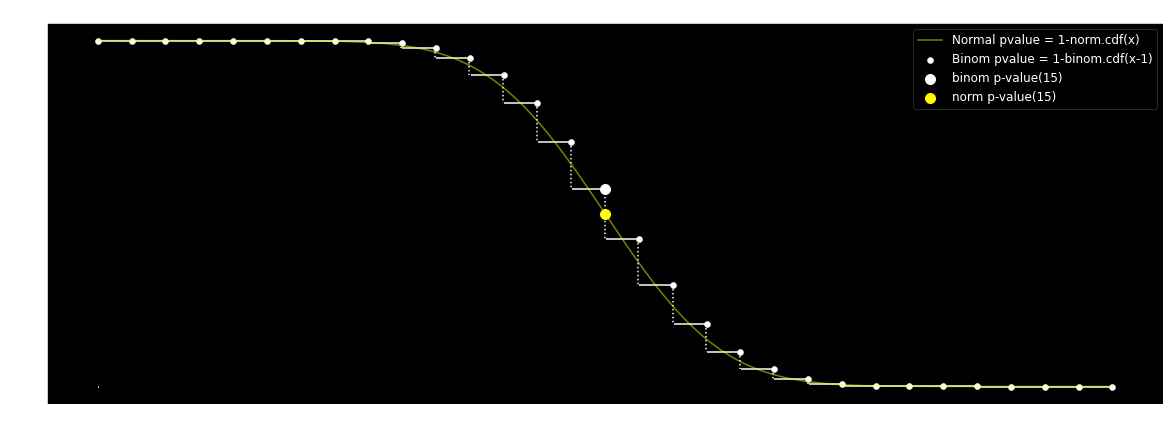

In [25]:
cmp_pvalue_binom_and_norm(30, 0.5, 15)

Везде видно, что биномиальное p-value выше pvalue, полученного нормальной аппроксимацией. В идеальной аппроксимации белая и желтая точки должны были находиться на одной высоте. Но при этом, чем больше n или чем ближе к концам графика t, тем меньше разница между точками, и тем точнее аппроксимация.


In [26]:
n = 20
t = 10

old_p_value = get_pvalue_by_old_logic(n, mu0, t)
print(f"p-value, полученное по старой, корректной формуле: {old_p_value}")
normal_dist_p_value = get_pvalue_by_normal_approx(n, mu0, t)
print(f"p-value, полученное из приближения нормальным распределением: {normal_dist_p_value}")
print(f"Разница: {round(abs(old_p_value - normal_dist_p_value), 3)}")

p-value, полученное по старой, корректной формуле: 0.5880985260009768
p-value, полученное из приближения нормальным распределением: 0.5
Разница: 0.088


In [27]:
# При росте t
n = 20
t = 14

old_p_value = get_pvalue_by_old_logic(n, mu0, t)
print(f"p-value, полученное по старой, корректной формуле: {old_p_value}")
normal_dist_p_value = get_pvalue_by_normal_approx(n, mu0, t)
print(f"p-value, полученное из приближения нормальным распределением: {normal_dist_p_value}")
print(f"Разница: {round(abs(old_p_value - normal_dist_p_value), 3)}")

p-value, полученное по старой, корректной формуле: 0.057659149169921875
p-value, полученное из приближения нормальным распределением: 0.03681913506015133
Разница: 0.021


In [28]:
# при росте n
n = 200
t = 100

old_p_value = get_pvalue_by_old_logic(n, mu0, t)
print(f"p-value, полученное по старой, корректной формуле: {old_p_value}")
normal_dist_p_value = get_pvalue_by_normal_approx(n, mu0, t)
print(f"p-value, полученное из приближения нормальным распределением: {normal_dist_p_value}")
print(f"Разница: {round(abs(old_p_value - normal_dist_p_value), 3)}")

p-value, полученное по старой, корректной формуле: 0.5281742395046416
p-value, полученное из приближения нормальным распределением: 0.5
Разница: 0.028


Но как сделать так, чтобы два p-value совпали? Для этого я предлагаю обратить внимание, где белая (горизонтальная часть) и желтая линии пересекаются: если бы мы желтую точку брали на пересечении 2 линий, то мы получили бы абсолютно точное значение p-value. 

Как именно ее найти? Заметим, что вообще-то они пересекаются примерно на середине отрезка: между t-1 и t. Поэтому попробуем "сдвинуть" график нормального распределения на 1/2 вправо.

- $F_{\text{new}}(x) = F_{\text{old}}(x - 0.5)$ Например, $F_{\text{new}}(10) = F_{\text{old}}(9.5)$

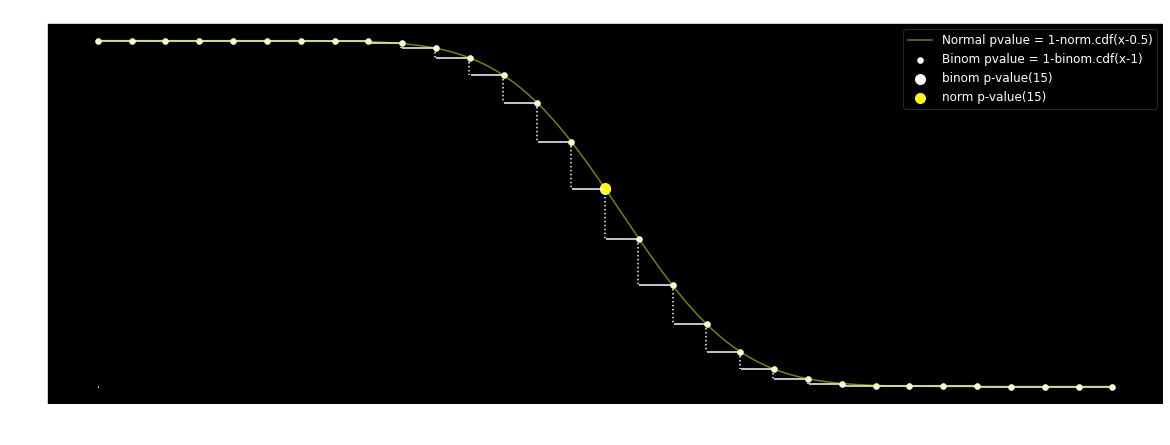

In [29]:
cmp_pvalue_binom_and_norm(30, 0.5, 15, add_to_x=-0.5)

Вот теперь визуально точки совпали! Проверим полученные pvalue:

In [30]:
def get_pvalue_by_normal_approx_with_addition(n, mu0, t):
    sum_mu = n * mu0
    sum_variance = n * mu0 * (1 - mu0)
    sum_std = numpy.sqrt(sum_variance)

    return 1 - norm(loc=sum_mu, scale=sum_std).cdf(t - 0.5)

In [31]:
n = 30
mu0 = 0.5
t = 19

old_p_value = get_pvalue_by_old_logic(n, mu0, t)
print(f"p-value, полученное по старой, корректной формуле: {old_p_value}")
normal_dist_p_value = get_pvalue_by_normal_approx(n, mu0, t)
print(f"p-value, полученное из приближения нормальным распределением: {normal_dist_p_value}")
normal_with_add_p_value = get_pvalue_by_normal_approx_with_addition(n, mu0, t)
print(f"p-value, полученное из приближения нормальным распределением с поправкой: {normal_with_add_p_value}")

p-value, полученное по старой, корректной формуле: 0.10024421103298664
p-value, полученное из приближения нормальным распределением: 0.07206351740800765
p-value, полученное из приближения нормальным распределением с поправкой: 0.10062131047886202


Отлично! Мы научились решать старую задачку новым методом. Поправка 1/2 называется **поправкой на непрерывность [continuity correction](https://en.wikipedia.org/wiki/Continuity_correction).**

Теперь давайте добавим эту поправку в критерий Фишера:

In [32]:
def z_criterion_pvalue(sample_mean, sample_size, mu0, variance, use_continuity_correction=False):
    if use_continuity_correction:
        # корректируем значение суммы, как делали это ранее
        sample_mean = (sample_mean * sample_size - 1/2) / sample_size
    Z_statistic = numpy.sqrt(sample_size) * (sample_mean - mu0) / numpy.sqrt(variance)
    return 1 - norm().cdf(Z_statistic) 

Проверим, что все корректно:

In [33]:
n = 30
t = 19
mu0 = 0.5
variance = mu0 * (1 - mu0)

old_p_value = get_pvalue_by_old_logic(n, mu0, t)
print(f"p-value, полученное по старой, корректной формуле: {old_p_value}")
normal_with_add_p_value = get_pvalue_by_normal_approx_with_addition(n, mu0, t)
print(f"p-value, полученное из приближения нормальным распределением с поправкой: {normal_with_add_p_value}")
z_pvalue = z_criterion_pvalue(t/n, n, mu0, variance, use_continuity_correction=True)
print(f"Z-тест p-value: {z_pvalue}")

p-value, полученное по старой, корректной формуле: 0.10024421103298664
p-value, полученное из приближения нормальным распределением с поправкой: 0.10062131047886202
Z-тест p-value: 0.10062131047886202


Ура, что все сошлось! Мы получили более точный критерий!

Единственное, на что надо обратить внимание: в Z-критерий в качестве аргумента нужно передавать дисперсию выборки. В нашей текущей задаче мы ее знали, потому что тут была простая выборка Бернулли, в которой дисперсия напрямую выражается через мат. ожидание.

Но что делать, у нас более сложное распределение у выборки и дисперсия неизвестна? Об этом узнаем на следующем занятии!

----

## Итог

В этом занятии мы:
- Вспомнили, что такое нормальное распределение и какие у него есть свойства.
- Вспомнили, как формулируется Центральная предельная теорема и как ее можно использовать.
- Узнали про Z-критерий Фишера и решили с его помощью задачу про конверсии.
    - Кроме того, на практике увидели, что такое поправка на непрерывность и зачем она нужна.
    - Единственное но: мы подсветили, что в этом критерии нужно знать дисперсию выборки. Но на практике она не всегда известна.